# Finding the error bar when interpolating the measurements

The RF losses in the T-resonator, due to the metal resistivities of the coaxial lines, is relatively unknown as the resisitivity that one can find in textbooks is in practice never achieved in real-life. 

In this notebook, the measured return loss of the propely matched T-resonator is compared to the RF model. The short-circuit lengths and resistivity and eventually the total RF losses in the model are adjusted to fit the measurement. This gives a estimation of the RF losses achieved in real-life.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tresonator as T

%matplotlib notebook

Below we import the return loss measurements.

In [313]:
# Load a matched configuration - S-parameter measurements
filename = 'data/RES2.ASC'

exp_freq_SSA50,reS11,imS11 = np.loadtxt(filename, skiprows=14, delimiter=';', unpack=True)
exp_mag = np.sqrt(reS11**2 + imS11**2)
exp_mag_dB_SSA50 = 20*np.log10(exp_mag)

s = reS11 + 1j*imS11
freq_SSA50 = rf.Frequency.from_f(exp_freq_SSA50, unit='Hz')
SSA50 = rf.Network(frequency=freq_SSA50, s=s)
SSA50.frequency.unit = 'MHz'
exp_mag_dB_SSA50 = SSA50.s_db.squeeze()

exp_freq_match_SSA50 = exp_freq_SSA50[np.argmin(exp_mag_dB)]


In [356]:
SSA84 = rf.Network('data/SSA84_TaskB_resonator_matched_3.s1p')
SSA84.frequency.unit='MHz'
#SSA84 = tres_exp.interpolate(rf.Frequency(61.3, 61.8, npoints=1001, unit='MHz'))
exp_freq_match_SSA84 = tres_exp.f[np.argmin(tres_exp.s_mag)]
exp_mag_dB_SSA84 = tres_exp.s11.s_db.squeeze()
exp_freq_SSA84 = tres_exp.f # for later use

In [357]:
exp_freq_match_SSA50 = SSA50.f[np.argmin(SSA50.s_db)]
exp_freq_match_SSA84 = SSA84.f[np.argmin(SSA84.s_db)]
delta_f = exp_freq_match_SSA50 - exp_freq_match_SSA84

In [358]:
SSA84_shifted = SSA84.copy()
SSA84_shifted.frequency.unit = 'Hz'
SSA84_shifted.f += delta_f
SSA84_shifted.frequency.unit = 'MHz'

SSA84_shifted.name = 'SSA84 (shifted)'
SSA84.name = 'SSA84'
SSA50.name = 'SSA50'

Calculating the Q factor from S-param

In [399]:
f_match_SSA84 = SSA84.f[np.argmin(SSA84.s11.s_db)]
f_match_SSA50 = SSA50.f[np.argmin(SSA50.s11.s_db)]

z_in_SSA84 = SSA84.z.squeeze()
z_in_SSA50 = SSA50.z.squeeze()

X_SSA84 = z_in_SSA84.imag
X_SSA50 = z_in_SSA50.imag
w_SSA84 = SSA84.frequency.w
w_SSA50 = SSA50.frequency.w


<IPython.core.display.Javascript object>


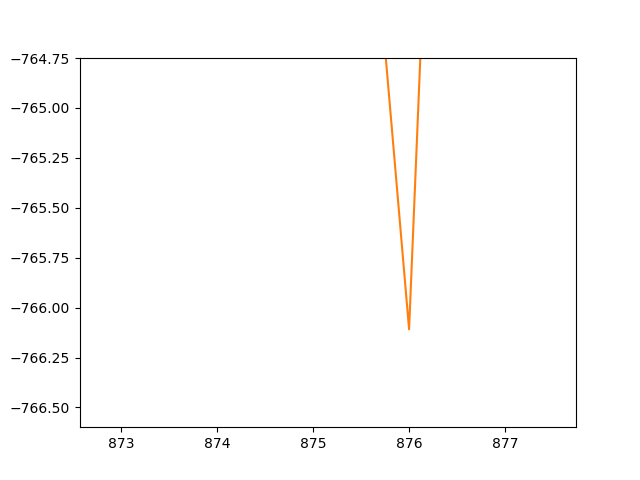

In [398]:
fig, ax = plt.subplots()
ax.plot(w_SSA84/(2*(z_in_SSA84.real + 50))*np.gradient(X_SSA84)/np.gradient(w_SSA84))
ax.plot(w_SSA50/(2*(z_in_SSA50.real + 50))*np.gradient(X_SSA50)/np.gradient(w_SSA50))


In [375]:
dX_dw = len()

array([3.83274304e+08, 3.83283729e+08, 3.83293153e+08, ...,
       3.92680232e+08, 3.92689657e+08, 3.92699082e+08])

<IPython.core.display.Javascript object>


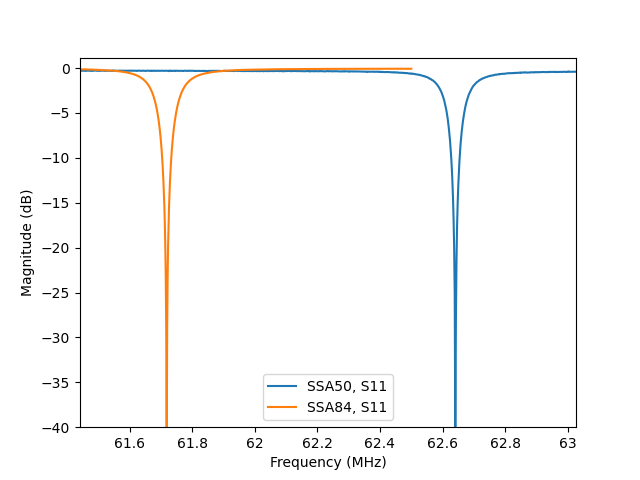

(-40.0, 2.0)

In [359]:
fig, ax=plt.subplots()
SSA50.plot_s_db(ax=ax)
SSA84.plot_s_db(ax=ax)
ax.set_xlim(61e6, 64e6)
ax.set_ylim(-40, 2)

<IPython.core.display.Javascript object>


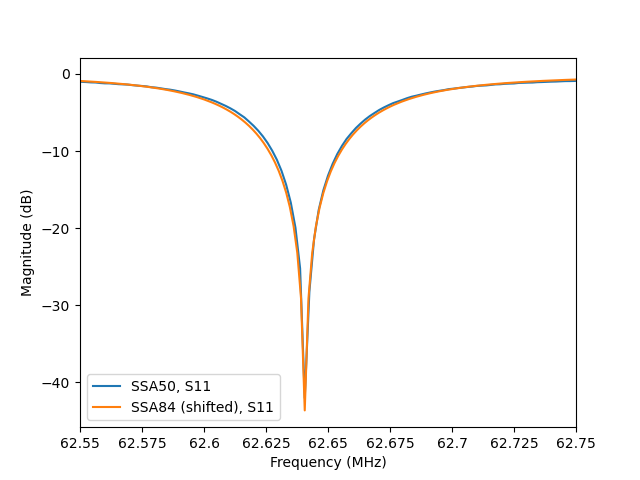

(62550000.0, 62750000.0)

In [360]:
fix, ax = plt.subplots()
SSA50.plot_s_db(ax=ax)
SSA84_shifted.plot_s_db(ax=ax)
ax.set_xlim(62.55e6, 62.75e6)

Near the resonance, the input impedance of a resonator describes a nearly perfect circle in the complex plane [Ginzton1957, Kajfez1984]:

<IPython.core.display.Javascript object>


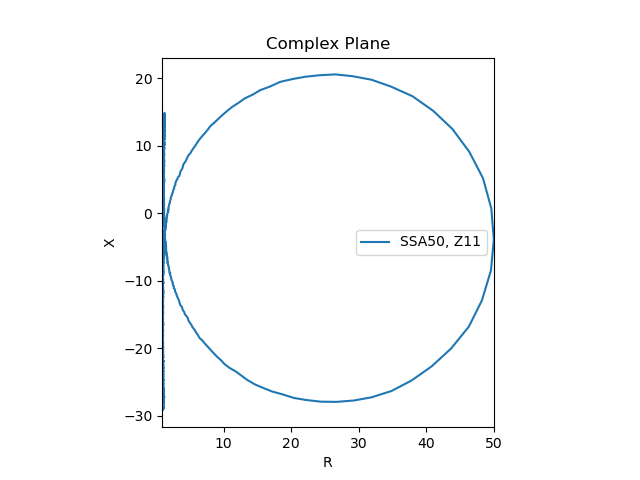

Text(0, 0.5, 'X')

In [355]:
fig, ax = plt.subplots()
SSA50.plot_z_complex(ax=ax)
ax.set_aspect('equal')
ax.set_xlabel('R')
ax.set_ylabel('X')

<IPython.core.display.Javascript object>


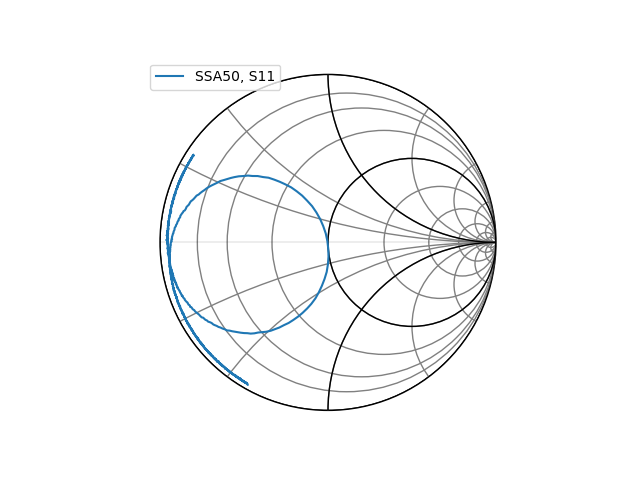

In [352]:
fig, ax = plt.subplots()
SSA50.plot_s_smith(ax=ax)

In [348]:
def Q(f, v, thres=3):
    idx_f_match = rf.find_nearest_index(v, v.min())
    f_match = f[idx_f_match]
    
    print(f'Resonance frequency f0={f_match/1e6} MHz')

    idx_f_low = rf.find_nearest_index(v[:idx_f_match], thres)
    idx_f_upp = rf.find_nearest_index(v[idx_f_match:], thres) + idx_f_match
    print(f'-3 dB frequencies: f1={f[idx_f_low]/1e6} MHz and f2={f[idx_f_upp]/1e6} MHz, ')

    Deltaf = f[idx_f_upp] - f[idx_f_low]
    print(f'Delta_f = f2 - f1 = {Deltaf/1e6} MHz')

    Q = f[idx_f_match] / Deltaf
    print(f'Q={Q}')

In [349]:
Q(SSA50.f, SSA50.s_db.squeeze(), SSA50.s_db.max() - 3)
Q(SSA84.f, SSA84.s_db.squeeze(), SSA84.s_db.max() - 3)


Resonance frequency f0=62.640625 MHz
-3 dB frequencies: f1=62.60125 MHz and f2=62.681875 MHz, 
Delta_f = f2 - f1 = 0.080625 MHz
Q=776.937984496124
Resonance frequency f0=61.7395 MHz
-3 dB frequencies: f1=61.6975 MHz and f2=61.783 MHz, 
Delta_f = f2 - f1 = 0.0855 MHz
Q=722.0994152046784


In [271]:
def z_in_RLC_parallel(f, R, L, C):
    return 1/(1/R + 1/(1j*2*rf.pi*f*L) + 1j*2*rf.pi*f*C)

def optim_fun_z_in(RLCs, subfreq='62.5-63MHz'):
    R, L, C = RLCs
    # calculates the resonator S11 vs freq
    z_in = [z_in_RLC_parallel(f, R, L, C) for f in SSA50[subfreq].f]
    
    crit = np.sum( (np.abs(np.array(z_in)) - SSA50[subfreq].z_mag.squeeze() )**2) #least square 
    print(R, L, C, crit)
    return crit  

In [273]:
# find a optimum taking into account additional losses
R0, L0, C0 = 0.00001, 1e-3, 1e-4
bounds_pties = ((0, 10000), # R 
                (1e-30, 1), # L
                (1e-30, 1)) # C
opt_res = minimize(optim_fun_z_in, (R0, L0, C0), bounds=bounds_pties)
R, L, C = opt_res.x
print(R, L, C)

1e-05 0.001 0.0001 77579.56932491886
1.001e-05 0.001 0.0001 77579.56927260499
1e-05 0.00100001 0.0001 77579.56932491886
1e-05 0.001 0.00010001 77579.56932573082
5231.387341150522 0.001 1e-30 7299271101.085838
5231.387341160522 0.001 1e-30 7299271101.113802
5231.387341150522 0.00100001 1e-30 7299271126.841877
5231.387341150522 0.001 1e-08 75947.67804796333
1748.506535491782 0.001 6.657661888118617e-05 77579.38205566048
1748.5065355017819 0.001 6.657661888118617e-05 77579.38205566048
1748.506535491782 0.00100001 6.657661888118617e-05 77579.38205566048
1748.506535491782 0.001 6.658661888118617e-05 77579.38209286201
581.9619397985849 0.001 8.88755717564007e-05 77579.4442069497
581.9619398085849 0.001 8.88755717564007e-05 77579.4442069497
581.9619397985849 0.00100001 8.88755717564007e-05 77579.4442069497
581.9619397985849 0.001 8.888557175640069e-05 77579.44422782613
193.69657204687883 0.001 9.629741501086139e-05 77579.4585085543
193.69657205687884 0.001 9.629741501086139e-05 77579.45850855

<IPython.core.display.Javascript object>


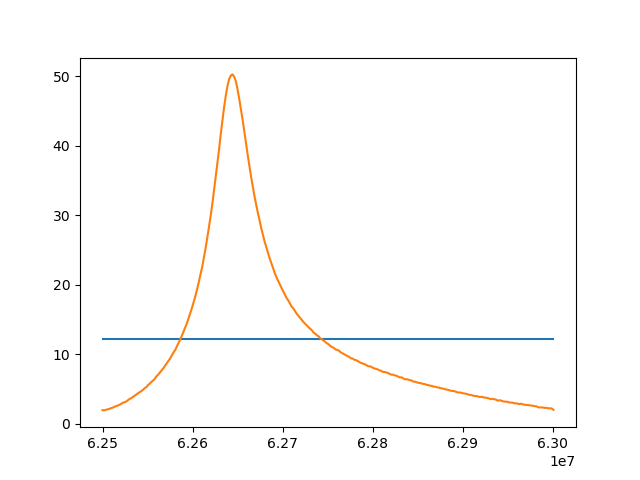

In [274]:
fig, ax = plt.subplots()
subfreq='62.5-63MHz'
ax.plot(SSA50[subfreq].f, np.abs([z_in_RLC_parallel(f, *opt_res.x) for f in SSA50[subfreq].f]))
ax.plot(SSA50[subfreq].f, SSA50[subfreq].z_mag.squeeze())

In [202]:
Q(SSA50.f, SSA50.s_db.squeeze())
Q(SSA84.f, SSA84.s_db.squeeze())


Resonance frequency f0=62.640625 MHz
-3 dB frequencies: f1=61.0 MHz and f2=63.1075 MHz, 
Delta_f = f2 - f1 = 2.1075 MHz
Q=29.722716488730725
Resonance frequency f0=61.572 MHz
-3 dB frequencies: f1=60.04 MHz and f2=62.0 MHz, 
Delta_f = f2 - f1 = 1.96 MHz
Q=31.414285714285715


<IPython.core.display.Javascript object>


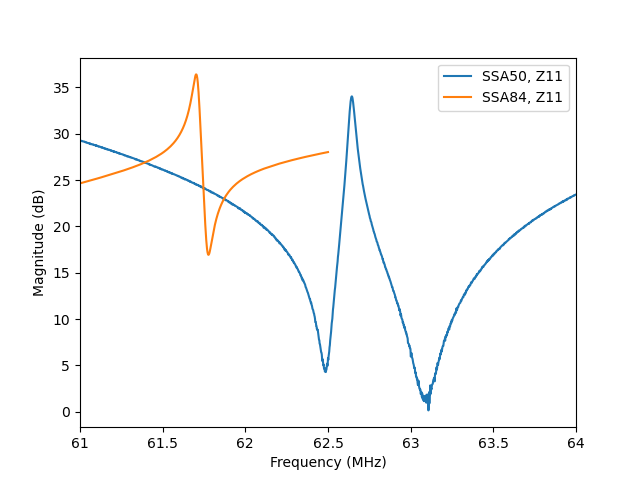

Resonance frequency f0=63.1075 MHz
-3 dB frequencies: f1=62.665 MHz and f2=64.0 MHz, 
Delta_f = f2 - f1 = 1.335 MHz
Q=47.27153558052434
Resonance frequency f0=63.1075 MHz
-3 dB frequencies: f1=62.665 MHz and f2=64.0 MHz, 
Delta_f = f2 - f1 = 1.335 MHz
Q=47.27153558052434
Resonance frequency f0=63.1075 MHz
-3 dB frequencies: f1=63.094375 MHz and f2=63.1075 MHz, 
Delta_f = f2 - f1 = 0.013125 MHz
Q=4808.190476190476
Resonance frequency f0=61.777 MHz
-3 dB frequencies: f1=61.7755 MHz and f2=61.777 MHz, 
Delta_f = f2 - f1 = 0.0015 MHz
Q=41184.666666666664


In [275]:
fig, ax = plt.subplots()
SSA50.plot_z_db()
SSA84.plot_z_db()

Q(SSA50.f, SSA50.z_mag.squeeze(), thres=0.707*SSA50.z_mag.max())
Q(SSA50.f, SSA50.z_db.squeeze(), thres=SSA50.z_db.max() - 3)
Q(SSA50.f, SSA50.z_db.squeeze(), thres=SSA50.s_db.min() - 3)
Q(SSA84.f, SSA84.z_mag.squeeze())


 The match frequency found in practice is:  

In [6]:
# find the match frequency 
exp_freq_match = exp_freq[np.argmin(exp_mag)]
print('Match frequency : {} MHz'.format(exp_freq_match/1e6))

Match frequency : 62.640625 MHz


Then we define an optimization function. The goal of this function is to minimize the error between the measured S11 and the simulated one, for the whole frequency band.

In [7]:
def optim_fun_impedance(short_properties, use_add_loss):
    L_DUT, Z_DUT, L_CEA, Z_CEA, add_loss = short_properties
    # calculates the resonator S11 vs freq
    S11dB = []
    for f in exp_freq:
        if not use_add_loss: # force no additional loss is requested
            add_loss = 1
        _cfg = T.Configuration(f, P_in=1, L_DUT=L_DUT, L_CEA=L_CEA, 
                               Z_short_DUT=Z_DUT, Z_short_CEA=Z_CEA, 
                               additional_losses=add_loss)
        S11dB.append(_cfg.S11dB())
    
    crit = np.sum( (np.array(S11dB) - exp_mag_dB)**2) #least square 
    print(short_properties, crit)
    return crit  

Below we launch the minimization process, starting from first guess.

Two minimization are launches: one taking into account a multiplicative loss coefficient, and one without.

In [8]:
# first guess
d_DUT_0 = 0.035 # m
d_CEA_0 = 0.035 # m
Z_DUT_0 = 0.01 # Ohm
Z_CEA_0 = 0.01 # Ohm
add_loss = 1.0 # multiplicative coefficient on total RF loss

In [9]:
# find a optimum taking into account additional losses
bounds_pties = ((20e-3, 63e-3), (1e-3, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-3, 1), # d,Z CEA
                (0.1, 2)) # add losses
opt_res = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, add_loss),
                  bounds=bounds_pties, args=(True))

[0.035 0.01  0.035 0.01  1.   ] 9956.686465532102
[0.03500001 0.01       0.035      0.01       1.        ] 9956.702965904995
[0.035      0.01000001 0.035      0.01       1.        ] 9956.684455598182
[0.035      0.01       0.03500001 0.01       1.        ] 9956.687130777014
[0.035      0.01       0.035      0.01000001 1.        ] 9956.68555547423
[0.035      0.01       0.035      0.01       1.00000001] 9956.686416454628
[0.02  1.    0.005 1.    2.   ] 6430.982456966881
[0.02000001 1.         0.005      1.         2.        ] 6430.982422324432
[0.02       0.99999999 0.005      1.         2.        ] 6430.982456548172
[0.02       1.         0.00500001 1.         2.        ] 6430.982443633074
[0.02       1.         0.005      0.99999999 2.        ] 6430.98245594576
[0.02       1.         0.005      1.         1.99999999] 6430.982456923171
[0.02024813 1.         0.00512956 1.         2.        ] 6429.953005427562
[0.02024814 1.         0.00512956 1.         2.        ] 6429.952971247703
[0

[0.03931446 0.09282881 0.08048006 0.09473161 0.82755104] 7106.887615079389
[0.03931446 0.09282881 0.08048005 0.09473162 0.82755104] 7106.887614973939
[0.03931446 0.09282881 0.08048005 0.09473161 0.82755105] 7106.887623184101
[0.03182913 0.12184942 0.04270823 0.12435356 1.05747863] 5934.231725896853
[0.03182914 0.12184942 0.04270823 0.12435356 1.05747863] 5934.233067186382
[0.03182913 0.12184943 0.04270823 0.12435356 1.05747863] 5934.231755909756
[0.03182913 0.12184942 0.04270824 0.12435356 1.05747863] 5934.232770920165
[0.03182913 0.12184942 0.04270823 0.12435357 1.05747863] 5934.231724305331
[0.03182913 0.12184942 0.04270823 0.12435356 1.05747864] 5934.23172600241
[0.03075468 0.12601507 0.03728641 0.12860553 1.09048274] 5515.9470589704115
[0.03075469 0.12601507 0.03728641 0.12860553 1.09048274] 5515.945697720326
[0.03075468 0.12601508 0.03728641 0.12860553 1.09048274] 5515.947110853722
[0.03075468 0.12601507 0.03728642 0.12860553 1.09048274] 5515.947323224129
[0.03075468 0.12601507 0.

[0.03663391 0.001      0.02274006 0.00483506 0.94328937] 2118.4488275439194
[0.03267465 0.001      0.0335701  0.00430905 0.95346048] 392.1326620379573
[0.03267466 0.001      0.0335701  0.00430905 0.95346048] 392.1181118417994
[0.03267465 0.00100001 0.0335701  0.00430905 0.95346048] 392.1311447651226
[0.03267465 0.001      0.03357011 0.00430905 0.95346048] 392.12574913255605
[0.03267465 0.001      0.0335701  0.00430906 0.95346048] 392.1320334153257
[0.03267465 0.001      0.0335701  0.00430905 0.95346049] 392.13262741745035
[0.063 1.    0.005 1.    2.   ] 8635.860155471053
[0.06299999 1.         0.005      1.         2.        ] 8635.858716545059
[0.063      0.99999999 0.005      1.         2.        ] 8635.860169176724
[0.063      1.         0.00500001 1.         2.        ] 8635.859609179057
[0.063      1.         0.005      0.99999999 2.        ] 8635.860159412849
[0.063      1.         0.005      1.         1.99999999] 8635.860155709954
[0.04221715 0.31535613 0.02457992 0.31762392 1.

[0.03302091 0.00313488 0.03262287 0.00647762 0.95505821] 173.80695984999866
[0.0330209  0.00313489 0.03262287 0.00647762 0.95505821] 173.76760867876914
[0.0330209  0.00313488 0.03262288 0.00647762 0.95505821] 173.78294200629063
[0.0330209  0.00313488 0.03262287 0.00647763 0.95505821] 173.76660790594576
[0.0330209  0.00313488 0.03262287 0.00647762 0.95505822] 173.76598201818967
[0.03307211 0.00318059 0.03247812 0.00653156 0.95449475] 162.89664093030345
[0.03307212 0.00318059 0.03247812 0.00653156 0.95449475] 162.90400002310804
[0.03307211 0.0031806  0.03247812 0.00653156 0.95449475] 162.8965613534875
[0.03307211 0.00318059 0.03247813 0.00653156 0.95449475] 162.89914964254962
[0.03307211 0.00318059 0.03247812 0.00653157 0.95449475] 162.8965994016877
[0.03307211 0.00318059 0.03247812 0.00653156 0.95449476] 162.89663876151025
[0.03324491 0.00373401 0.03198245 0.0071082  0.95381066] 161.2310880093765
[0.03324492 0.00373401 0.03198245 0.0071082  0.95381066] 161.23421597033132
[0.03324491 0.0

[0.0330979  0.00342427 0.0323879  0.00677914 0.95429849] 159.82330223547007
[0.0330979  0.00342426 0.03238791 0.00677914 0.95429849] 159.82344936124002
[0.0330979  0.00342426 0.0323879  0.00677915 0.95429849] 159.82330267298812
[0.0330979  0.00342426 0.0323879  0.00677914 0.9542985 ] 159.823303582849
[0.0330979  0.00342426 0.0323879  0.00677914 0.95429849] 159.82330363072802
[0.03309791 0.00342426 0.0323879  0.00677914 0.95429849] 159.82372376591724
[0.0330979  0.00342427 0.0323879  0.00677914 0.95429849] 159.82330223517198
[0.0330979  0.00342426 0.03238791 0.00677914 0.95429849] 159.8234493609624
[0.0330979  0.00342426 0.0323879  0.00677915 0.95429849] 159.82330267268173
[0.0330979  0.00342426 0.0323879  0.00677914 0.9542985 ] 159.82330358254816
[0.0330979  0.00342426 0.0323879  0.00677914 0.95429849] 159.82330363066544
[0.03309791 0.00342426 0.0323879  0.00677914 0.95429849] 159.82372376586733
[0.0330979  0.00342427 0.0323879  0.00677914 0.95429849] 159.82330223511087
[0.0330979  0.0

[0.03309772 0.00344533 0.03238737 0.00680014 0.95432059] 159.81443928561487
[0.03309772 0.00344533 0.03238736 0.00680015 0.95432059] 159.81444047672
[0.03309772 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.81444047937933
[0.03309772 0.00344533 0.03238736 0.00680014 0.95432059] 159.81444047496234
[0.03309773 0.00344533 0.03238736 0.00680014 0.95432059] 159.81444682135222
[0.03309772 0.00344534 0.03238736 0.00680014 0.95432059] 159.81444027398706
[0.03309772 0.00344533 0.03238737 0.00680014 0.95432059] 159.81443928013198
[0.03309772 0.00344533 0.03238736 0.00680015 0.95432059] 159.81444047029976
[0.03309772 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.81444047297333
[0.03309772 0.00344533 0.03238736 0.00680014 0.95432059] 159.81444047454158
[0.03309773 0.00344533 0.03238736 0.00680014 0.95432059] 159.81444682110273
[0.03309772 0.00344534 0.03238736 0.00680014 0.95432059] 159.81444027357202
[0.03309772 0.00344533 0.03238737 0.00680014 0.95432059] 159.8144392797766
[0.03309772 0.00

In [10]:
# find a optimum taking into account additional losses
bounds_pties = ((20e-3, 63e-3), (1e-3, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-3, 1), # d,Z CEA
                (0.1, 2)) # add losses
opt_res_noloss = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, add_loss),
                  bounds=bounds_pties, args=(False))


[0.035 0.01  0.035 0.01  1.   ] 9956.686465532102
[0.03500001 0.01       0.035      0.01       1.        ] 9956.702965904995
[0.035      0.01000001 0.035      0.01       1.        ] 9956.684455598182
[0.035      0.01       0.03500001 0.01       1.        ] 9956.687130777014
[0.035      0.01       0.035      0.01000001 1.        ] 9956.68555547423
[0.035      0.01       0.035      0.01       1.00000001] 9956.686465532102
[0.02  1.    0.005 1.    1.   ] 6426.6652751467045
[0.02000001 1.         0.005      1.         1.        ] 6426.6652351112725
[0.02       0.99999999 0.005      1.         1.        ] 6426.66527478101
[0.02       1.         0.00500001 1.         1.        ] 6426.665263314429
[0.02       1.         0.005      0.99999999 1.        ] 6426.665274144747
[0.02       1.         0.005      1.         1.00000001] 6426.6652751467045
[0.0203025  1.         0.00510005 1.         1.        ] 6425.3432104685435
[0.02030251 1.         0.00510005 1.         1.        ] 6425.34317115625

[0.03337407 0.0868357  0.03976826 0.08941607 1.        ] 5869.855629137477
[0.03337407 0.08683569 0.03976827 0.08941607 1.        ] 5869.857271782034
[0.03337407 0.08683569 0.03976826 0.08941608 1.        ] 5869.855604472702
[0.03337407 0.08683569 0.03976826 0.08941607 1.00000001] 5869.855627036538
[0.0314544  0.001      0.03988913 0.003922   1.        ] 5925.234390144674
[0.03145441 0.001      0.03988913 0.003922   1.        ] 5925.272789006294
[0.0314544  0.00100001 0.03988913 0.003922   1.        ] 5925.232796239886
[0.0314544  0.001      0.03988914 0.003922   1.        ] 5925.245860110363
[0.0314544  0.001      0.03988913 0.00392201 1.        ] 5925.233637084389
[3.14543962e-02 1.00000000e-03 3.98891307e-02 3.92199862e-03
 1.00000001e+00] 5925.234390144674
[0.03231089 0.0392972  0.0398352  0.04206678 1.        ] 5483.487271335742
[0.0323109  0.0392972  0.0398352  0.04206678 1.        ] 5483.496725760216
[0.03231089 0.03929721 0.0398352  0.04206678 1.        ] 5483.4872244975995
[0.

[0.04289566 0.001      0.00500001 0.00520886 1.        ] 3634.220739936552
[0.04289566 0.001      0.005      0.00520887 1.        ] 3634.2204031155475
[4.28956561e-02 1.00000000e-03 5.00000000e-03 5.20885503e-03
 1.00000001e+00] 3634.220770381058
[0.03395126 0.001      0.03008589 0.00422458 1.        ] 871.5039292109308
[0.03395127 0.001      0.03008589 0.00422458 1.        ] 871.5205138318332
[0.03395126 0.00100001 0.03008589 0.00422458 1.        ] 871.5026426183381
[0.03395126 0.001      0.0300859  0.00422458 1.        ] 871.5082357189891
[0.03395126 0.001      0.03008589 0.00422459 1.        ] 871.503363794456
[3.39512581e-02 1.00000000e-03 3.00858878e-02 4.22458011e-03
 1.00000001e+00] 871.5039292109308
[0.03244609 0.001      0.03430734 0.00405895 1.        ] 248.42050002344376
[0.0324461  0.001      0.03430734 0.00405895 1.        ] 248.50215327523466
[0.03244609 0.00100001 0.03430734 0.00405895 1.        ] 248.4205961653946
[0.03244609 0.001      0.03430735 0.00405895 1.        ]

[0.03313507 0.00278184 0.0322886  0.00594238 1.        ] 159.94251926610053
[0.03313507 0.00278184 0.03228859 0.00594239 1.        ] 159.94312467214058
[0.03313507 0.00278184 0.03228859 0.00594238 1.00000001] 159.94315313813897
[0.03312785 0.00277452 0.03230828 0.00593427 1.        ] 159.87503219992692
[0.03312786 0.00277452 0.03230828 0.00593427 1.        ] 159.8739689335419
[0.03312785 0.00277453 0.03230828 0.00593427 1.        ] 159.87498284933673
[0.03312785 0.00277452 0.03230829 0.00593427 1.        ] 159.8745798510443
[0.03312785 0.00277452 0.03230828 0.00593428 1.        ] 159.87501251407122
[0.03312785 0.00277452 0.03230828 0.00593427 1.00000001] 159.87503219992692
[0.03310603 0.00274151 0.03236844 0.00589872 1.        ] 159.8293790636883
[0.03310604 0.00274151 0.03236844 0.00589872 1.        ] 159.8288478538716
[0.03310603 0.00274152 0.03236844 0.00589872 1.        ] 159.82935824439832
[0.03310603 0.00274151 0.03236845 0.00589872 1.        ] 159.82916067084096
[0.03310603 0.00

[0.03309903 0.0027373  0.03238754 0.00589375 1.        ] 159.82842838331015
[0.03309903 0.0027373  0.03238754 0.00589374 1.00000001] 159.82843164747823
[0.03309903 0.0027373  0.03238754 0.00589374 1.        ] 159.8284316474829
[0.03309904 0.0027373  0.03238754 0.00589374 1.        ] 159.82831927474723
[0.03309903 0.00273731 0.03238754 0.00589374 1.        ] 159.8284232450471
[0.03309903 0.0027373  0.03238755 0.00589374 1.        ] 159.82837960563558
[0.03309903 0.0027373  0.03238754 0.00589375 1.        ] 159.82842838330964
[0.03309903 0.0027373  0.03238754 0.00589374 1.00000001] 159.8284316474829
[0.03309903 0.0027373  0.03238754 0.00589374 1.        ] 159.8284316474761
[0.03309904 0.0027373  0.03238754 0.00589374 1.        ] 159.828319274742
[0.03309903 0.00273731 0.03238754 0.00589374 1.        ] 159.82842324504298
[0.03309903 0.0027373  0.03238755 0.00589374 1.        ] 159.82837960564143
[0.03309903 0.0027373  0.03238754 0.00589375 1.        ] 159.82842838331106
[0.03309903 0.0027

[0.03309773 0.00275686 0.0323903  0.00591319 1.00000001] 159.82378937071212
[0.03309761 0.00275832 0.0323905  0.00591464 1.        ] 159.82397410168127
[0.03309762 0.00275832 0.0323905  0.00591464 1.        ] 159.82399444812862
[0.03309761 0.00275833 0.0323905  0.00591464 1.        ] 159.82397466390813
[0.03309761 0.00275832 0.03239051 0.00591464 1.        ] 159.8239791640089
[0.03309761 0.00275832 0.0323905  0.00591465 1.        ] 159.82397452688087
[0.03309761 0.00275832 0.0323905  0.00591464 1.00000001] 159.82397410168127
[0.0330977  0.00275718 0.03239034 0.00591351 1.        ] 159.82376907754156
[0.03309771 0.00275718 0.03239034 0.00591351 1.        ] 159.82400307276924
[0.0330977  0.00275719 0.03239034 0.00591351 1.        ] 159.82377170957818
[0.0330977  0.00275718 0.03239035 0.00591351 1.        ] 159.82385260195358
[0.0330977  0.00275718 0.03239034 0.00591352 1.        ] 159.82377015987925
[0.0330977  0.00275718 0.03239034 0.00591351 1.00000001] 159.82376907754156
[0.03309763 0

[0.03309767 0.00275748 0.03239038 0.0059138  1.        ] 159.82372051796986
[0.03309768 0.00275748 0.03239038 0.0059138  1.        ] 159.82375005285516
[0.03309767 0.00275749 0.03239038 0.0059138  1.        ] 159.82372096850315
[0.03309767 0.00275748 0.03239039 0.0059138  1.        ] 159.82372876675046
[0.03309767 0.00275748 0.03239038 0.00591381 1.        ] 159.8237208854407
[0.03309767 0.00275748 0.03239038 0.0059138  1.00000001] 159.82372051796986
[0.03309767 0.00275747 0.03239038 0.00591379 1.        ] 159.8237205285269
[0.03309768 0.00275747 0.03239038 0.00591379 1.        ] 159.82374722488692
[0.03309767 0.00275748 0.03239038 0.00591379 1.        ] 159.82372094722194
[0.03309767 0.00275747 0.03239039 0.00591379 1.        ] 159.8237277308846
[0.03309767 0.00275747 0.03239038 0.0059138  1.        ] 159.82372088540797
[0.03309767 0.00275747 0.03239038 0.00591379 1.00000001] 159.8237205285269


Now the results:

In [11]:
print(f'With losses: \t\t d_DUT_0={opt_res.x[0]:.3}, Z_DUT_0={opt_res.x[1]:.3}',
        f' d_CEA_0={opt_res.x[2]:.3}, Z_CEA_0={opt_res.x[3]:.3}, add_loss={opt_res.x[4]:.3}')

print(f'Without losses: \t d_DUT_0={opt_res_noloss.x[0]:.3}, Z_DUT_0={opt_res_noloss.x[1]:.3},', 
      f'd_CEA_0={opt_res_noloss.x[2]:.3}, Z_CEA_0={opt_res_noloss.x[3]:.3}')


With losses: 		 d_DUT_0=0.0331, Z_DUT_0=0.00345  d_CEA_0=0.0324, Z_CEA_0=0.0068, add_loss=0.954
Without losses: 	 d_DUT_0=0.0331, Z_DUT_0=0.00276, d_CEA_0=0.0324, Z_CEA_0=0.00591


Graphically:

<IPython.core.display.Javascript object>


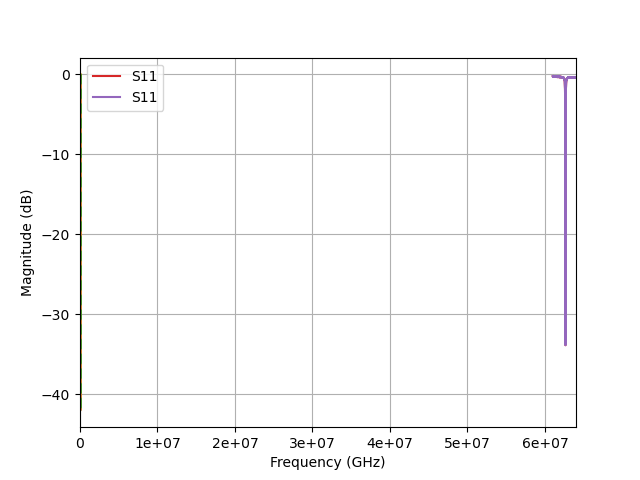

(62.5, 62.8)

In [16]:
P_in = 20e3 # W

S11dB = []
S11dB_noloss = []

L_DUT_opt, Z_DUT_opt, L_CEA_opt, Z_CEA_opt, add_loss_opt = opt_res.x
L_DUT_opt_nl, Z_DUT_opt_nl, L_CEA_opt_nl, Z_CEA_opt_nl, add_loss_opt_nl = opt_res_noloss.x

for f in exp_freq:
    _cfg = T.Configuration(f, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)
    S11dB.append(_cfg.S11dB())
    
    _cfg = T.Configuration(f, P_in, L_DUT_opt_nl, L_CEA_opt_nl, 
                           Z_short_DUT = Z_DUT_opt_nl, Z_short_CEA = Z_CEA_opt_nl, 
                           additional_losses=add_loss_opt_nl)
    S11dB_noloss.append(_cfg.S11dB())    
    

fig,ax=plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB, lw=2)
ax.plot(exp_freq/1e6, S11dB, lw=2)
ax.plot(exp_freq/1e6, S11dB_noloss, lw=2, ls='--')
ax.legend(('Measurement', 'TL model - with add. losses', 'TL model - no add. losses'))
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')
ax.set_xlim(62.5, 62.8)

## Quality Factor

Calculating the Quality factor Q as:
$$
Q = \frac{f_0}{\Delta f}
$$
where $\Delta f$ is the 3 dB bandwidth and $f_0$ the resonating frequency.

In [13]:
import skrf as rf

In [14]:
S11_max = exp_mag_dB.max()
S11_min_idx = rf.find_nearest_index(exp_mag_dB, exp_mag_dB.min())
print(f'Resonance frequency f0={exp_freq[S11_min_idx]/1e6} MHz')

S11_Deltaf_low_idx = rf.find_nearest_index(exp_mag_dB[:S11_min_idx], S11_max - 3)
S11_Deltaf_upp_idx = rf.find_nearest_index(exp_mag_dB[S11_min_idx:], S11_max - 3) + S11_min_idx
print(f'-3 dB frequencies: f1={exp_freq[S11_Deltaf_low_idx]/1e6} MHz, f1={exp_freq[S11_Deltaf_upp_idx]/1e6} MHz, ')



Resonance frequency f0=62.640625 MHz
-3 dB frequencies: f1=62.60125 MHz, f1=62.681875 MHz, 


In [15]:
Deltaf = exp_freq[S11_Deltaf_upp_idx] - exp_freq[S11_Deltaf_low_idx]
print(f'Delta_f = {Deltaf/1e6} MHz')

Q = exp_freq[S11_min_idx] / Deltaf
print(f'Q={Q}')
      

Delta_f = 0.080625 MHz
Q=776.937984496124
